In [1]:
from functions import *

In [2]:
df = get_games()
df.head()

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:32<00:00,  1.08s/it]


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22023,1610612737,ATL,Atlanta Hawks,0022300533,2024-01-12,ATL vs. IND,L,242,108,...,0.739,12,16,28.0,25,14,2,14,13,-18.0
1,22023,1610612737,ATL,Atlanta Hawks,0022300521,2024-01-10,ATL vs. PHI,W,265,139,...,0.738,16,39,55.0,32,6,8,12,21,7.0
2,22023,1610612737,ATL,Atlanta Hawks,0022300499,2024-01-07,ATL @ ORL,L,265,110,...,0.586,8,42,50.0,21,9,10,12,23,-7.0
3,22023,1610612737,ATL,Atlanta Hawks,0022300480,2024-01-05,ATL @ IND,L,238,116,...,0.867,14,25,39.0,21,6,3,14,11,-34.0
4,22023,1610612737,ATL,Atlanta Hawks,0022300467,2024-01-03,ATL vs. OKC,W,240,141,...,0.939,15,34,49.0,30,8,5,11,21,3.0


In [3]:
df.to_csv("RawDF.csv", index=False)

In [4]:
df = pd.read_csv("RawDF.csv")

In [5]:
# Creating a column to indicate if the home team is playing
df['Home'] = 1
# Creating a list of indices to include 
inds_to_include = []
# Iterating through the rows
for (index, row) in tqdm(df.iterrows()):
    # Getting rid of the first character on the SEASON_ID
    row.SEASON_ID = str(row.SEASON_ID)[1:]
    df.loc[index, 'SEASON_ID'] = row.SEASON_ID
    # Setting home games
    if '@' in row.MATCHUP:
        df.loc[index, 'Home'] = 0
    
    # Setting the WL column to be binary instead of W or L
    if row.WL == 'W':
        df.loc[index, 'WL'] = 1
    else:
        df.loc[index, 'WL'] = 0

    # Only including the in-season months
    month = int(row.GAME_DATE.split('-')[1])
    day = int(row.GAME_DATE.split('-')[2])
    if month < 7 or month > 9:
        if month == 10 and day > 20:
            inds_to_include.append(index)
        elif month > 10 or month < 7:
            inds_to_include.append(index)

# Dropping necessary columns and resetting indices
df = df.loc[inds_to_include, :]
df.drop(columns = ['TEAM_NAME', 'MATCHUP'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(len(inds_to_include))
df.head()

80176it [00:31, 2544.47it/s]

74461


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,WL,MIN,PTS,FGM,FGA,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,Home
0,2023,1610612737,ATL,22300533,2024-01-12,0,242,108,40,89,...,12,16,28.0,25,14,2,14,13,-18.0,1
1,2023,1610612737,ATL,22300521,2024-01-10,1,265,139,48,102,...,16,39,55.0,32,6,8,12,21,7.0,1
2,2023,1610612737,ATL,22300499,2024-01-07,0,265,110,42,91,...,8,42,50.0,21,9,10,12,23,-7.0,0
3,2023,1610612737,ATL,22300480,2024-01-05,0,238,116,40,93,...,14,25,39.0,21,6,3,14,11,-34.0,0
4,2023,1610612737,ATL,22300467,2024-01-03,1,240,141,48,95,...,15,34,49.0,30,8,5,11,21,3.0,1


In [6]:
quant_cols = ['MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS']

def calculate_streaks(series):
    # Initialize streak counters
    WStreak, LStreak = 0, 0
    streaks = []
    for result in series:
        if result == 1:
            WStreak += 1
            LStreak = 0
        elif result == 0:
            LStreak += 1
            WStreak = 0
        else:
            WStreak, LStreak = 0, 0  # Reset streaks for non-W/L results
        streaks.append((WStreak, LStreak))
    return streaks

def helper_func(group):
    # Sort in ascending order by date
    group['GAME_DATE'] = pd.to_datetime(group['GAME_DATE'])
    group.sort_values(by='GAME_DATE', ascending=True, inplace=True)
    
    # Replace any columns that have NA's with 0 
    group.fillna(0, inplace=True)
    
    # Create running averages for quantitative columns
    group[quant_cols] = group[quant_cols].expanding(1).sum().shift(1).copy()
    group['Count'] = group['GAME_DATE'].expanding(1).count().shift(1).copy()
    for col in quant_cols:
        group[col] = group[col] / group['Count']
    
    # Convert WL column into a win percentage
    group['WIN_PCT'] = group['WL'].expanding(1).sum().shift(1).copy() / group['Count']
    
    # Calculate win/loss streaks
    streaks = calculate_streaks(group['WL'])
    group['WStreak'], group['LStreak'] = zip(*streaks)
    group[['WStreak', 'LStreak']] = group[['WStreak', 'LStreak']].shift(1)
    group[['WStreak', 'LStreak']].fillna(0, inplace=True)

    # Compute Home Win Percentage
    home_games_mask = group['Home'] == 1
    home_wins = group['WL'][home_games_mask].expanding().apply(lambda x: (x == 1).sum())
    total_home_games = home_games_mask.expanding().sum()
    group['HomeWinPct'] = home_wins / total_home_games
    group['HomeWinPct'].fillna(method='ffill', inplace=True)  # Set away game values correctly
    group['HomeWinPct'] = group['HomeWinPct'].shift(1).fillna(0)

    # Remove the Count column
    group.drop(columns='Count', inplace=True)

    return group

# Sort by unique SEASON_ID and TEAM_ID, apply the helper_func(), drop all the NA's and reset the indices
running_totals = df.groupby(['SEASON_ID', 'TEAM_ID']).apply(helper_func).dropna().reset_index(drop=True)
running_totals[running_totals['TEAM_ABBREVIATION'] == 'DET'].tail(50)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,WL,MIN,PTS,FGM,FGA,...,STL,BLK,TOV,PF,PLUS_MINUS,Home,WIN_PCT,WStreak,LStreak,HomeWinPct
72367,2022,1610612765,DET,22201042,2023-03-16,0,241.753623,111.188406,39.826087,87.594203,...,7.173913,3.884058,14.463768,22.159420,-7.521739,1,0.217391,0.0,1.0,0.228571
72368,2022,1610612765,DET,22201066,2023-03-19,0,241.714286,111.028571,39.814286,87.557143,...,7.185714,3.871429,14.500000,22.128571,-7.685714,1,0.214286,0.0,2.0,0.222222
72369,2022,1610612765,DET,22201078,2023-03-21,0,241.704225,110.873239,39.788732,87.478873,...,7.140845,3.845070,14.450704,22.098592,-7.746479,0,0.211268,0.0,3.0,0.216216
72370,2022,1610612765,DET,22201099,2023-03-24,0,241.666667,110.819444,39.750000,87.527778,...,7.152778,3.819444,14.375000,22.152778,-7.944444,0,0.208333,0.0,4.0,0.216216
72371,2022,1610612765,DET,22201122,2023-03-27,0,241.630137,110.630137,39.671233,87.328767,...,7.164384,3.821918,14.479452,22.095890,-8.123288,1,0.205479,0.0,5.0,0.216216
72372,2022,1610612765,DET,22201142,2023-03-29,0,241.621622,110.716216,39.689189,87.391892,...,7.135135,3.770270,14.418919,22.067568,-8.135135,0,0.202703,0.0,6.0,0.210526
72373,2022,1610612765,DET,22201155,2023-03-31,0,241.600000,110.653333,39.693333,87.293333,...,7.053333,3.760000,14.453333,22.066667,-8.040000,0,0.200000,0.0,7.0,0.210526
72374,2022,1610612765,DET,22201169,2023-04-02,0,241.592105,110.710526,39.736842,87.315789,...,7.052632,3.802632,14.421053,22.144737,-8.013158,0,0.197368,0.0,8.0,0.210526
72375,2022,1610612765,DET,22201177,2023-04-04,0,241.597403,110.597403,39.636364,87.194805,...,7.012987,3.766234,14.441558,22.233766,-8.246753,1,0.194805,0.0,9.0,0.210526
72376,2022,1610612765,DET,22201189,2023-04-05,0,241.589744,110.525641,39.589744,87.012821,...,6.987179,3.743590,14.435897,22.230769,-8.307692,1,0.192308,0.0,10.0,0.205128


In [7]:
# Create a dataframe for the matchups
match_df = pd.DataFrame()

for (index, row) in tqdm(running_totals.iterrows()):
    # Get the current team's id 
    team_id = row.TEAM_ID
    # Find the opponent's stats
    other_team = running_totals[(running_totals['GAME_ID'] == row.GAME_ID) & (running_totals['TEAM_ID'] != row.TEAM_ID)]
    # Drop the unnecessary/redundant columns
    other_team = other_team.drop(columns=['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'WL', 'Home'])
    # Reset the index
    other_team.reset_index(inplace=True, drop=True)
    # Create new columns with suffix _y for the other team
    new_cols = [col + "_y" for col in list(other_team.columns)]
    # Save new columns as the other team's columns
    other_team.columns = new_cols
    # Combine this team and other team data
    this_row = pd.DataFrame([row]).reset_index(drop=True)
    this_row = pd.concat((this_row, other_team), axis=1)
    #for col in list(other_team.columns):
        #this_row[col] = other_team[col]
    # Concatenate the new dataframe with this one 
    match_df = pd.concat((match_df, this_row))

73573it [03:46, 324.39it/s]


In [8]:
X = match_df.drop(columns=['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE']).dropna().reset_index(drop=True).apply(pd.to_numeric)
Y = X['WL'].copy()
X.drop(columns=['WL'], inplace=True)

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 419)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=2/len(X), random_state = 420)

# Scale the input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron, RidgeClassifierCV, RidgeClassifier, LogisticRegressionCV, RidgeCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB

In [10]:
# Define models 
mlp = MLPClassifier((12), activation='relu', tol=1e-8, max_iter=500)
logit = LogisticRegressionCV()
knn = KNeighborsClassifier(n_neighbors=150)
rf = RandomForestClassifier(max_depth=7, n_jobs=-1)
gb = GradientBoostingClassifier()

# Create a list of models 
models = [mlp, logit, knn, rf, gb]

# Fit each models to the training data
for model in tqdm(models):
    model.fit(X_train, Y_train)

# Assign weights based on ROC-AUC Score or Accuracy
weights = []
[weights.append(roc_auc_score(Y_train, model.predict(X_train))) for model in models]

# Normalize the weights
weights = [weight / sum(weights) for weight in weights]



100%|██████████| 5/5 [01:39<00:00, 19.86s/it]


In [11]:
class EnsembleMax:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights 
    
    def predict(self, X):
        preds = np.zeros((X.shape[0], len(self.models)))
        for j in range(len(self.models)):
            preds[:,j] = self.models[j].predict_proba(X)[:,1]
        
        means = np.mean(preds, axis=1)
        maxs = np.max(preds, axis=1)
        mins = np.min(preds, axis=1)

        final_preds = -np.ones_like(means)
        final_preds[means > 0.65] = maxs[means > 0.65]
        final_preds[means <= .35] = mins[means <= .35]
        final_preds[final_preds == -1] = means[final_preds == -1]
        
        final_preds = np.round(final_preds)
        return final_preds
        #return np.round(np.array(sum([weight * model.predict(X) for (weight, model) in zip(self.weights, self.models)])))

    def predict_proba(self, X):
        preds = np.zeros((X.shape[0], len(self.models)))
        for j in range(len(self.models)):
            preds[:,j] = self.models[j].predict_proba(X)[:,1]
        
        means = np.mean(preds, axis=1)
        maxs = np.max(preds, axis=1)
        mins = np.min(preds, axis=1)

        final_preds = -np.ones_like(means)
        final_preds[means > 0.65] = maxs[means > 0.65]
        final_preds[means <= .35] = mins[means <= .35]
        final_preds[final_preds == -1] = means[final_preds == -1]
        
        final_preds = np.reshape(final_preds, (len(final_preds), 1))
        return np.concatenate(((1-final_preds), final_preds), axis=1)
        #return np.array(sum([weight * model.predict_proba(X) for (weight, model) in zip(self.weights, self.models)]))
    
class Ensemble:
    def __init__(self, models, weights):
        self.models = models
        self.weights = weights 
    
    def predict(self, X):
        return np.round(np.array(sum([weight * model.predict(X) for (weight, model) in zip(self.weights, self.models)])))

    def predict_proba(self, X):
        return np.array(sum([weight * model.predict_proba(X) for (weight, model) in zip(self.weights, self.models)]))
# Create the ensemble
model = Ensemble(models, weights)

In [12]:
# Print the statistics
print("Train Accuracy: %.3f %%" % (100 * accuracy_score(Y_train, model.predict(X_train))))
print("Test  Accuracy: %.3f %%" % (100 * accuracy_score(Y_test, model.predict(X_test))))
print(confusion_matrix(Y_test, model.predict(X_test)))
print("Train ROC Score: %.4f" % (roc_auc_score(Y_train, model.predict_proba(X_train)[:,1])))
print("Test ROC Score: %.4f" % (roc_auc_score(Y_test, model.predict_proba(X_test)[:,1]))) if len(Y_test) > 50 else print("")

Train Accuracy: 67.328 %
Test  Accuracy: 50.000 %
[[1 1]
 [0 0]]
Train ROC Score: 0.7382



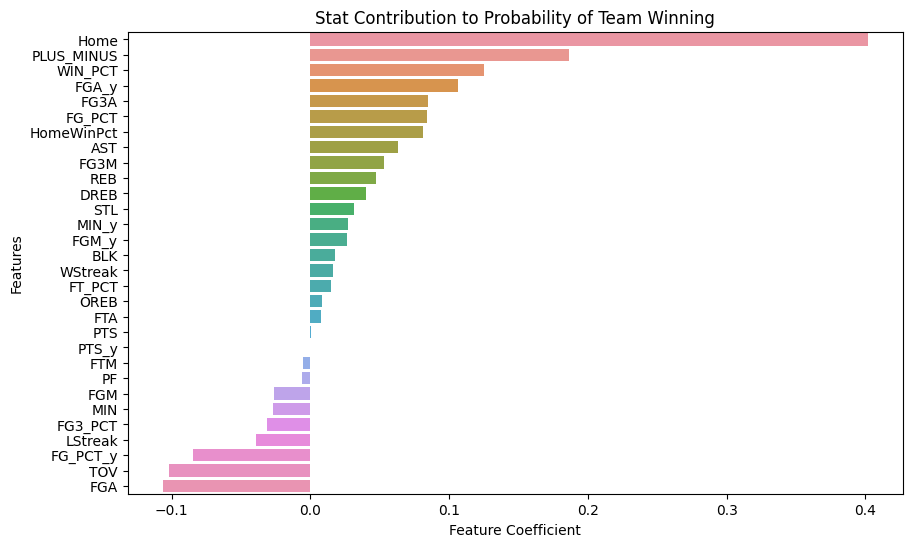

In [13]:
import seaborn as sns

importance_scores = logit.coef_[0]

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance_scores}).head(30)

# Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Feature Coefficient')
plt.ylabel('Features')
plt.title('Stat Contribution to Probability of Team Winning')
plt.show()

In [14]:
model = gb

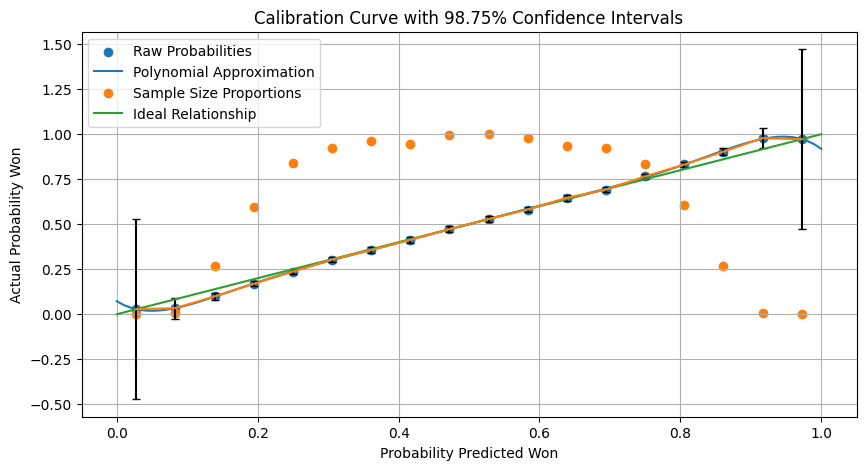

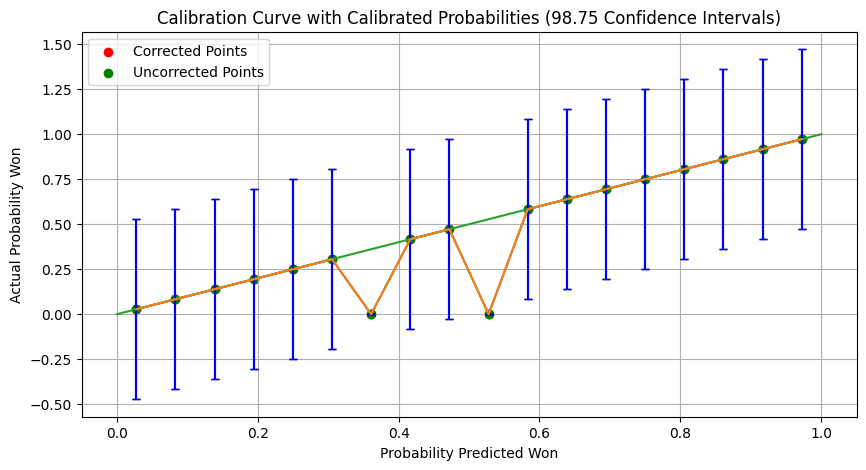

In [15]:
from sklearn.linear_model import LinearRegression
n_bins = 18
(bounds, probs, samples, errors) = prob_plot(Y_train, model.predict_proba(X_train)[:,1], bins=n_bins)

x_bounds = 0.5*(bounds[1:]+bounds[0:-1]).copy()
y_probs = probs.copy()

poly = PolynomialFeatures(7)
x_bounds_poly = poly.fit_transform(x_bounds.reshape(-1,1))

linear_model = LinearRegression()
linear_model.fit(x_bounds_poly, y_probs)

def conversion_func(x, linear_model, poly):
    x = poly.transform(x.reshape(-1,1))
    return linear_model.predict(x)

x_test = np.linspace(0,1,100)
x_test_poly = poly.transform(x_test.reshape(-1,1))
y_test = linear_model.predict(x_test_poly)

plt.figure(figsize=(10,5))
plt.scatter(x_bounds, y_probs, label = "Raw Probabilities")
plt.plot(x_test, y_test, label = "Polynomial Approximation")
plt.scatter(0.5*(bounds[1:]+bounds[0:-1]), samples / np.max(samples), label = "Sample Size Proportions")
plt.errorbar(0.5*(bounds[1:]+bounds[0:-1]), probs, yerr=errors, ecolor='black', capsize=3)
plt.plot([0,1], [0,1], label = "Ideal Relationship")
plt.grid()
plt.legend()
plt.xlabel("Probability Predicted Won")
plt.ylabel("Actual Probability Won")
plt.title("Calibration Curve with 98.75% Confidence Intervals")

plt.figure(figsize=(10,5))
(bounds, probs, samples, errors) = prob_plot(Y_test, conversion_func(model.predict_proba(X_test)[:,1], linear_model, poly), bins=n_bins)
plt.scatter(x_bounds, probs, c='red', label = "Corrected Points")
plt.errorbar(x_bounds, probs, yerr=errors, ecolor='black', capsize=3)
(bounds, probs, samples, errors) = prob_plot(Y_test, model.predict_proba(X_test)[:,1], bins=n_bins)
plt.scatter(x_bounds, probs, c='green', label="Uncorrected Points")
plt.errorbar(x_bounds, probs, yerr=errors, ecolor='blue', capsize=3)
plt.plot([0,1], [0,1])
plt.grid()
plt.xlabel("Probability Predicted Won")
plt.ylabel("Actual Probability Won")
plt.title("Calibration Curve with Calibrated Probabilities (98.75 Confidence Intervals)")
plt.legend()

In [16]:
quant_cols = ['MIN','PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS']
def helper_func_test(group):
    # Sort in ascending order by date
    group['GAME_DATE'] = pd.to_datetime(group['GAME_DATE'])
    group.sort_values(by='GAME_DATE', ascending=True, inplace=True)
    
    # Replace any columns that have NA's with 0 
    group.fillna(0, inplace=True)
    
    # Create running averages for quantitative columns
    group[quant_cols] = group[quant_cols].expanding(1).sum().copy()
    group['Count'] = group['GAME_DATE'].expanding(1).count().copy()
    for col in quant_cols:
        group[col] = group[col] / group['Count']
    
    # Convert WL column into a win percentage
    group['WIN_PCT'] = group['WL'].expanding(1).sum().copy() / group['Count']
    
    # Calculate win/loss streaks
    streaks = calculate_streaks(group['WL'])
    group['WStreak'], group['LStreak'] = zip(*streaks)
    #group[['WStreak', 'LStreak']] = group[['WStreak', 'LStreak']].shift(1)
    #group[['WStreak', 'LStreak']].fillna(0, inplace=True)

    # Compute Home Win Percentage
    home_games_mask = group['Home'] == 1
    home_wins = group['WL'][home_games_mask].expanding().apply(lambda x: (x == 1).sum())
    total_home_games = home_games_mask.expanding().sum()
    group['HomeWinPct'] = home_wins / total_home_games
    group['HomeWinPct'].fillna(method='ffill', inplace=True)  # Set away game values correctly
    #group['HomeWinPct'] = group['HomeWinPct'].shift(1).fillna(0)

    # Remove the Count column
    group.drop(columns='Count', inplace=True)

    return group

# Sort by unique SEASON_ID and TEAM_ID, apply the helper_func(), drop all the NA's and reset the indices
test_df = df.groupby(['SEASON_ID', 'TEAM_ID']).apply(helper_func_test).dropna().reset_index(drop=True)
test_df = test_df[test_df['SEASON_ID'] == '2023'].copy()
test_df.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,WL,MIN,PTS,FGM,FGA,...,STL,BLK,TOV,PF,PLUS_MINUS,Home,WIN_PCT,WStreak,LStreak,HomeWinPct
72624,2023,1610612737,ATL,22300079,2023-10-27,0,240.000000,115.000000,40.500000,90.000000,...,9.500000,3.500000,13.000000,19.500000,-6.000000,1,0.000000,0,2,0.000000
72625,2023,1610612737,ATL,22300097,2023-10-29,1,240.333333,119.000000,42.666667,91.000000,...,11.333333,3.000000,14.333333,18.666667,1.666667,0,0.333333,1,0,0.000000
72626,2023,1610612737,ATL,22300104,2023-10-30,1,239.750000,121.000000,44.000000,89.750000,...,10.000000,4.000000,13.000000,17.000000,4.750000,1,0.500000,2,0,0.500000
72627,2023,1610612737,ATL,22300117,2023-11-01,1,240.000000,122.800000,44.400000,90.200000,...,9.600000,3.800000,14.400000,16.800000,5.600000,1,0.600000,3,0,0.666667
72628,2023,1610612737,ATL,22300135,2023-11-04,1,240.166667,122.833333,44.500000,90.666667,...,8.666667,4.166667,13.833333,16.666667,7.666667,0,0.666667,4,0,0.666667


In [17]:
home_team = 'DEN'
away_team = 'NOP'
team1 = test_df[test_df['TEAM_ABBREVIATION'] == home_team].tail(1).copy() # Home Team
team2 = test_df[test_df['TEAM_ABBREVIATION'] == away_team].tail(1).copy()

for col in team1.columns:
    if '_y' in col:
        team1.drop(columns = [col], inplace=True)
        team2.drop(columns = [col], inplace=True)

# Set team1 as the home team 
team1["Home"] = 1
pd.concat((team1, team2)).head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,WL,MIN,PTS,FGM,FGA,...,STL,BLK,TOV,PF,PLUS_MINUS,Home,WIN_PCT,WStreak,LStreak,HomeWinPct
72888,2023,1610612743,DEN,22300539,2024-01-12,1,240.100000,116.175000,44.300000,89.425000,...,7.175000,5.400000,11.625000,18.975000,5.125000,1,0.675000,1,0,0.8
72770,2023,1610612740,NOP,22300539,2024-01-12,0,240.615385,116.358974,42.717949,87.820513,...,8.307692,4.871795,12.820513,19.512821,4.564103,0,0.589744,0,1,0.6


In [18]:
final_df = pd.DataFrame()
# Get the current team's id 
team_id = team1['TEAM_ID']
# Drop the unnecessary/redundant columns
team2.drop(columns=['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'WL', 'Home'], inplace=True)
# Reset the index
team1.reset_index(inplace=True, drop=True)
team2.reset_index(inplace=True, drop=True)
# Create new columns with suffix _y for the other team
new_cols = [col + "_y" for col in list(team2.columns)]
# Save new columns as the other team's columns
team2.columns = new_cols
# Combine this team and other team data
for col in list(team2.columns):
    team1[col] = team2[col]
# Concatenate the new dataframe with this one 
final_df = pd.concat((final_df, team1))

X_test_final = final_df.drop(columns=['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'WL']).dropna().reset_index(drop=True).apply(pd.to_numeric)
X_test_final = scaler.transform(X_test_final)

print("Probability that %s wins: %.2f%%" % (home_team, 100 * conversion_func(model.predict_proba(X_test_final)[0][1], linear_model, poly)))
print("Probability that %s wins: %.2f%%" % (away_team, 100 * conversion_func(model.predict_proba(X_test_final)[0][0], linear_model, poly)))

Probability that DEN wins: 65.63%
Probability that NOP wins: 34.21%


**Potential Features to Add**
- Elevation
- Points Allowed
- Time Since Last Game
- Avg. Margin of Victory
- Points, Assist, Rebound Leader Out